# 📊 VCGC vs SAHA-BELLETTI Flow
This is a draft to compare the performance on my proposed flow, VCGC, to the state-of-the-art flow, Saha-Belleti et al.
I would be comparing documenting and comparing the differences in the my proposed flow and the SOTA flow. 
VCGC is primarily based on the idea of using state-of-the-art logic synthesis and reversible circuit logic with a layered approach that opens room for optimizations.
Saha-Belletti et al. proposed flow is based on a monolothic architecture which uses invalid-color-detector and comparator oracles.   

## 📦 Packages
For the pupose of this research study, I independently developed and implemented the library for VCGC and repurposed the open-source code provided by [Analyzing, Fixing and Optimizing a Space-Efficient Quantum Circuit for the Graph K-Coloring Problem](https://github.com/Oscar-Belletti/Analyzing-Fixing-and-Optimizing-a-Space-Efficient-Quantum-Circuit-for-the-Graph-K-Coloring-Problem) by converting into a re-usable python library. _These libraries are essential in automating the synthesis of the circuits and generation of benchmark results._


### 1. Creating a Vertex Coloring Problem Network (VCP)
This will read from the DIMACS.col files which contain the benchamrks and parse it to be a VCPNetwork object which contains the metadata of the graph and a NetworkX representation of the graph. This will serve as the input to both of the libraries.

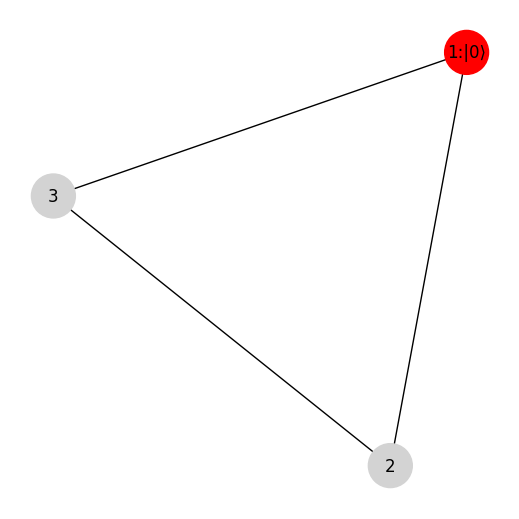

In [1]:
from vcgc.network import VCPNetwork

out_dir: str = "../data/vcgc_vs_saha_belletti/"
filename: str = "K3"
dimacs_filename: str = "../data/benchmarks/" + filename + ".col"

network = VCPNetwork(file_path=dimacs_filename)

graph_filename: str = out_dir + filename + ".png"
with open(graph_filename,"w+") as f:
    f.close()
    
# Display the graph
network.draw_graph(name=graph_filename, node_size=1000) # Draw nice graph using NetworkX

### 2. Grover Circuit Synthesis using VCGC
This will prepare the complete grover's circuit using the VCGC library.

#### 2.1 Extract the graph constraints

In [2]:
from vcgc.boolean import BooleanFunction

# Create Boolean function and display the constraints 
bf: BooleanFunction  = BooleanFunction()
bf.print_vertex_constraints(network=network)

(v1 != v2) ∧ (v1 != v3) ∧ (v2 != v3)



#### 2.2 Generate the corresponding Logic Network

Verilog file written to: ../data/vcgc_vs_saha_belletti/K3.v


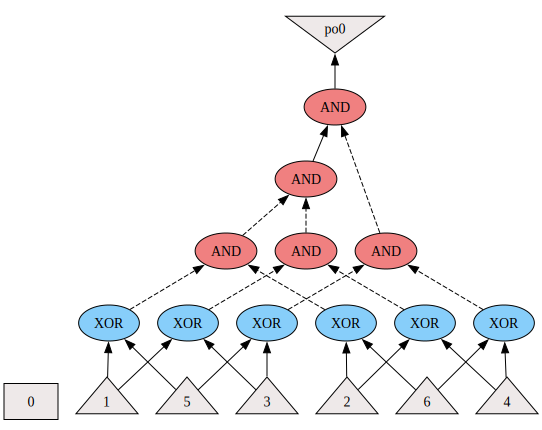

In [3]:
from tweedledum.bool_function_compiler.bool_function import BoolFunction
from tweedledum.classical import write_gate_dot, LogicNetwork
from graphviz import Source

# Generate tweedledum boolean function
tweedledum_bf: BoolFunction = bf.create_multi_bit_function(network=network)
logic_network: LogicNetwork = tweedledum_bf.logic_network()

# Write to Verilog
verilog_filename: str = out_dir + filename + ".v"
bf.write_verilog_file(network=network, filename=verilog_filename)

dot_filename: str = out_dir + filename + ".dot"

# Create a file with filename if it does not exist
with open(file=dot_filename, mode="w+") as f:
    f.close()

write_gate_dot(logic_network, dot_filename)

# Read and display the dot file
with open(dot_filename, 'r') as f:
    dot_content = f.read()

# Create and display the graph
graph = Source(dot_content)
# graph.view()  # This will open in external viewer
graph  # This will display inline in Jupyter notebook

#### 2.3 Set up XAG Synthesizer

In [4]:
from vcgc.synthesis import Synthesizer

synthesizer: Synthesizer = Synthesizer(cf=tweedledum_bf)

#### 2.4 Synthesize with XAG

In [5]:
from qiskit import QuantumCircuit

oracle_circuit_xag: QuantumCircuit = synthesizer.synthesize_with_xag()
# To output the circuit as ASCII art:
synthesizer.print_circuit_info()


Number of qubits: 11
                                                                          »
__a10 : ──────────────────────────────────────────────────────────────────»
                                                                          »
 __a9 : ──────────────────────────────────────────────────────────────────»
                                                                          »
 __a8 : ──────────────────────────────────────────────────────────────────»
                            ╭────╮                                        »
 __a7 : ────────────────────┤ rx ├────────────────────────────────────────»
                            ╰─┬──╯                                        »
 __q6 : ──────────────────────┼───────────────────────────────────────────»
                              │                                 ╭────────╮»
 __q5 : ──────────────────────┼─────────────────────────────────┤ parity ├»
                              │                       ╭────────╮╰──

#### 2.5 Display and Save the oracle circuit

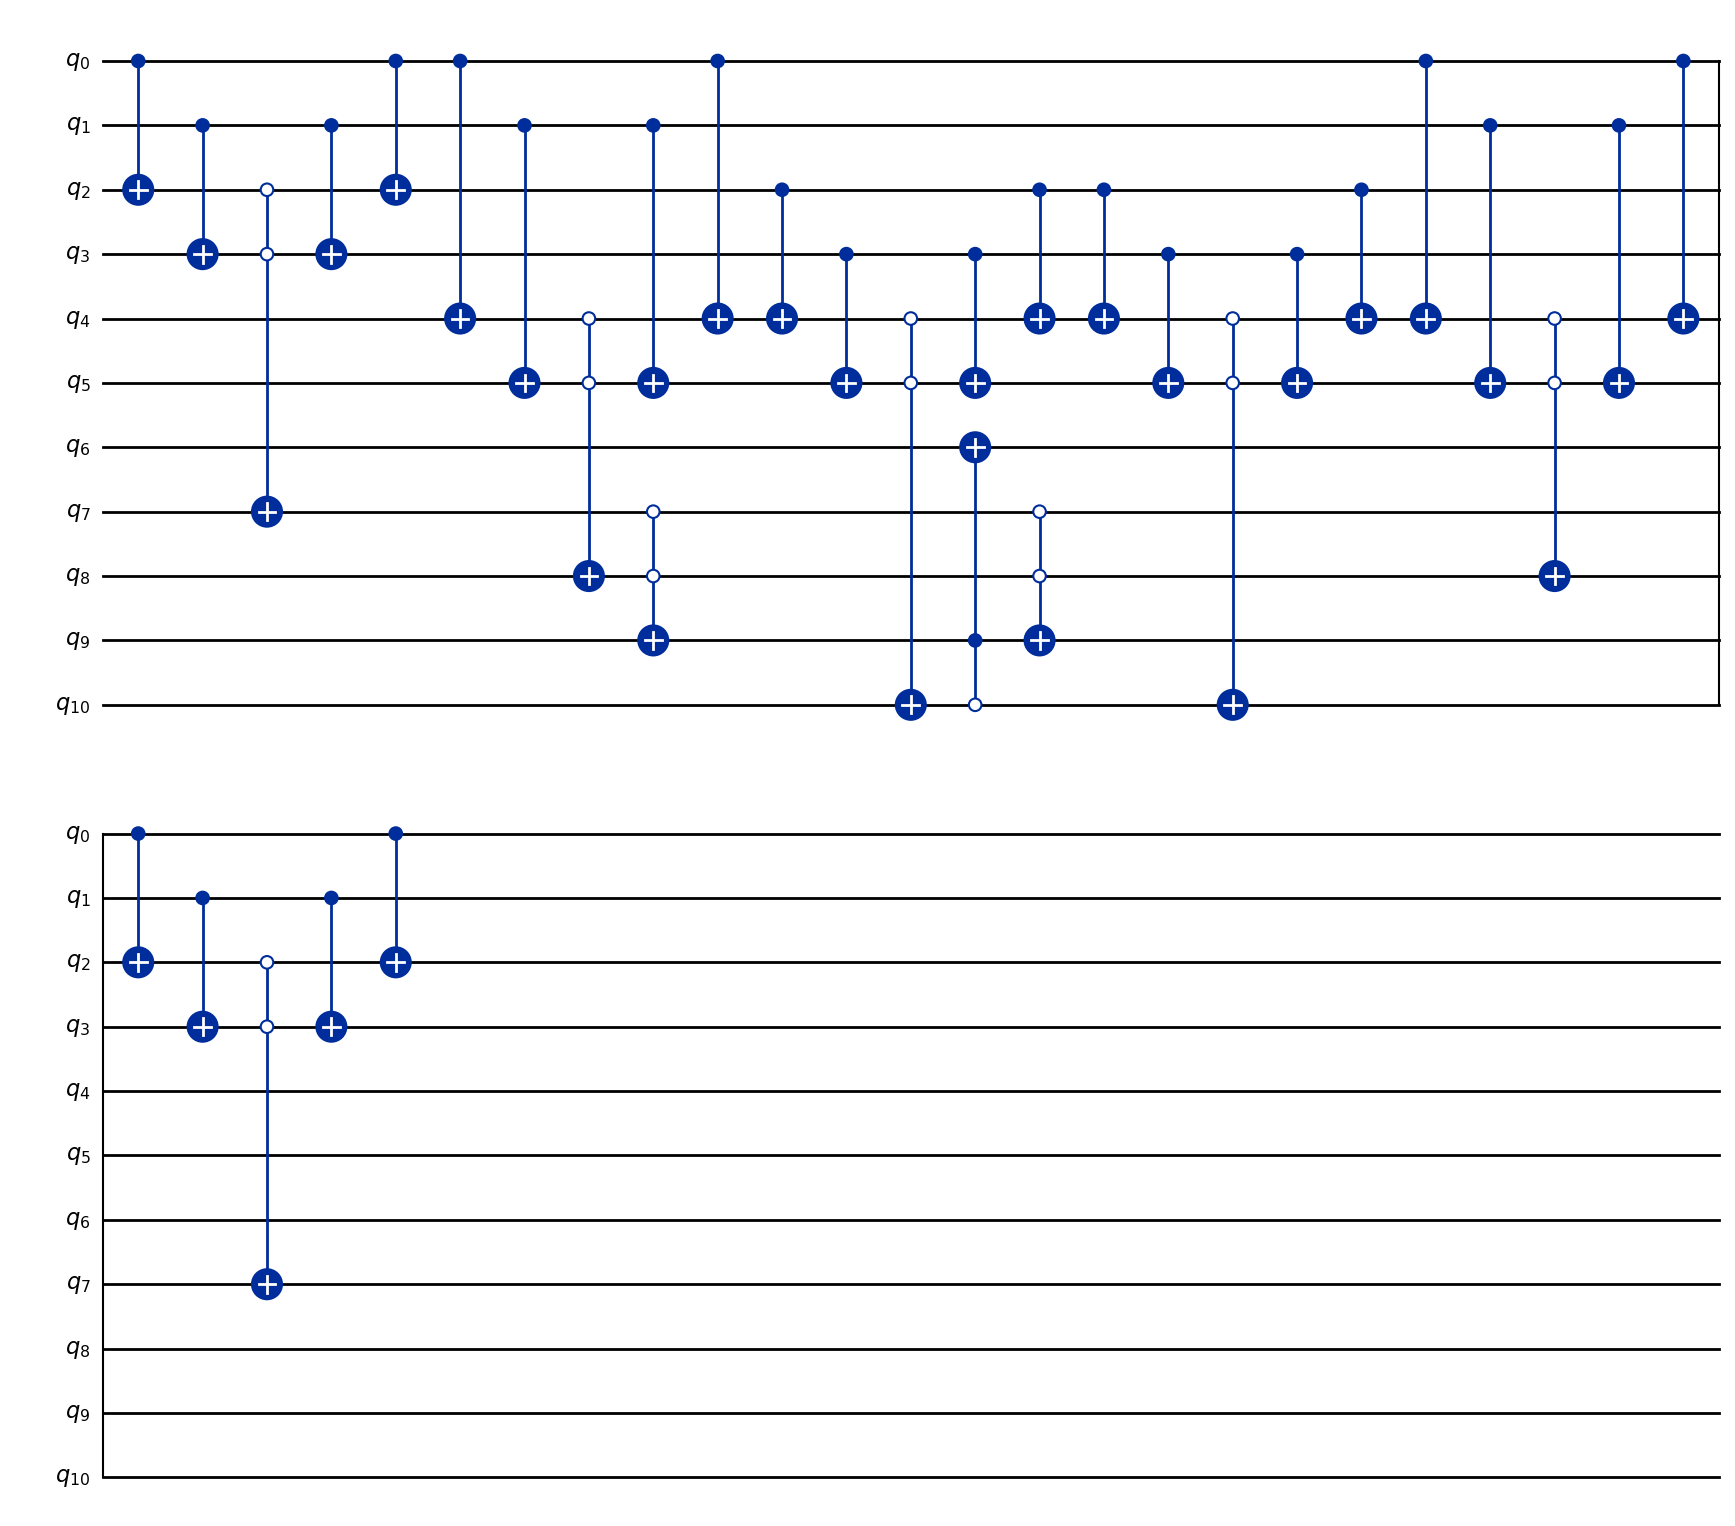

In [6]:
from qiskit.qasm3 import dump
qasm_filename: str = out_dir + filename + ".qasm"
with open(qasm_filename,"w") as f:
        dump(circuit=synthesizer.qiskit_circuit, stream=f)
oracle_circuit_xag.draw("mpl")

#### 2.6 Create Uniform Superposition State Preparation Oracle to Filter Out Invalid Encodings

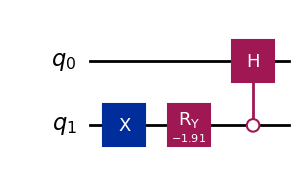

In [7]:
from vcgc.circuit import uniform_superposition_qiskit
from math import ceil, log2

num_superpos_states: int = network.available_colors
num_encode_qubits: int = ceil(log2(num_superpos_states)) # Leaving this here just for reference, it is done automatically
usp_oracle: QuantumCircuit = uniform_superposition_qiskit(num_superpos_states=num_superpos_states).decompose()
usp_oracle.draw(output="mpl")

#### 2.7 Verify the Uniform Distribution Through Analyzing the StateVector

In [8]:

from qiskit_aer import AerSimulator
from qiskit import transpile
import numpy as np

# Create statevector simulator
statevector_sim = AerSimulator(method='statevector')

# Run without measurement to get the statevector
qc_no_measurement = usp_oracle.copy()
qc_no_measurement.save_statevector()
compiled_sv_circuit = transpile(qc_no_measurement, statevector_sim)
job_sv = statevector_sim.run(compiled_sv_circuit)
result_sv = job_sv.result()
# Get the statevector
statevector = result_sv.get_statevector()

# Print amplitudes for each computational basis state
print("\nStatevector amplitudes:")
for i, amplitude in enumerate(statevector):
    if abs(amplitude) > 1e-10:  # Only show non-zero amplitudes
        probability = abs(amplitude)**2
        print(f"|{i:0{num_encode_qubits}b}⟩: amplitude = {amplitude:.4f}, probability = {probability:.4f}")

# Verify uniform distribution
expected_amplitude = 1/np.sqrt(num_superpos_states)
print(f"\nExpected amplitude for each state: {expected_amplitude:.4f}")
print(f"Expected probability for each state: {expected_amplitude**2:.4f}")


Statevector amplitudes:
|00⟩: amplitude = 0.5774-0.0000j, probability = 0.3333
|01⟩: amplitude = 0.5774+0.0000j, probability = 0.3333
|10⟩: amplitude = 0.5774-0.0000j, probability = 0.3333

Expected amplitude for each state: 0.5774
Expected probability for each state: 0.3333


/var/folders/tk/swjmm3f51fqbfbkckfb9cddm0000gn/T/ipykernel_98273/3774968417.py:19: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for i, amplitude in enumerate(statevector):


#### 2.8 Create the Respective Diffusion Operator

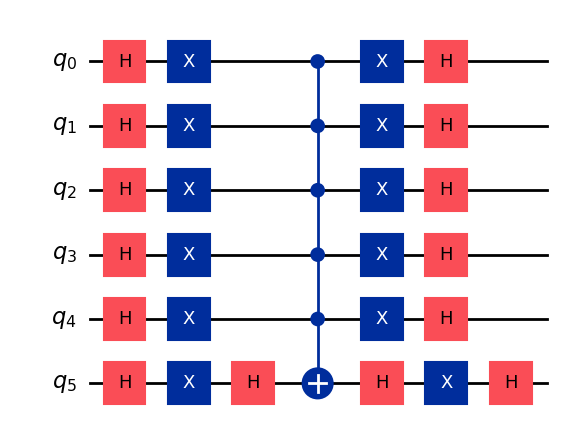

In [9]:
from vcgc.circuit import generate_grover_diffusion

num_data_qubits: int = network.num_vertices * num_encode_qubits
diff_oracle: QuantumCircuit = generate_grover_diffusion(num_qubits=num_data_qubits)
diff_oracle.draw(output="mpl")

#### 2.9 Glue the Complete Grover Circuit Together

Complete Grover Circuit:
Total qubits: 11
Circuit depth: 28
Number of gates: 73


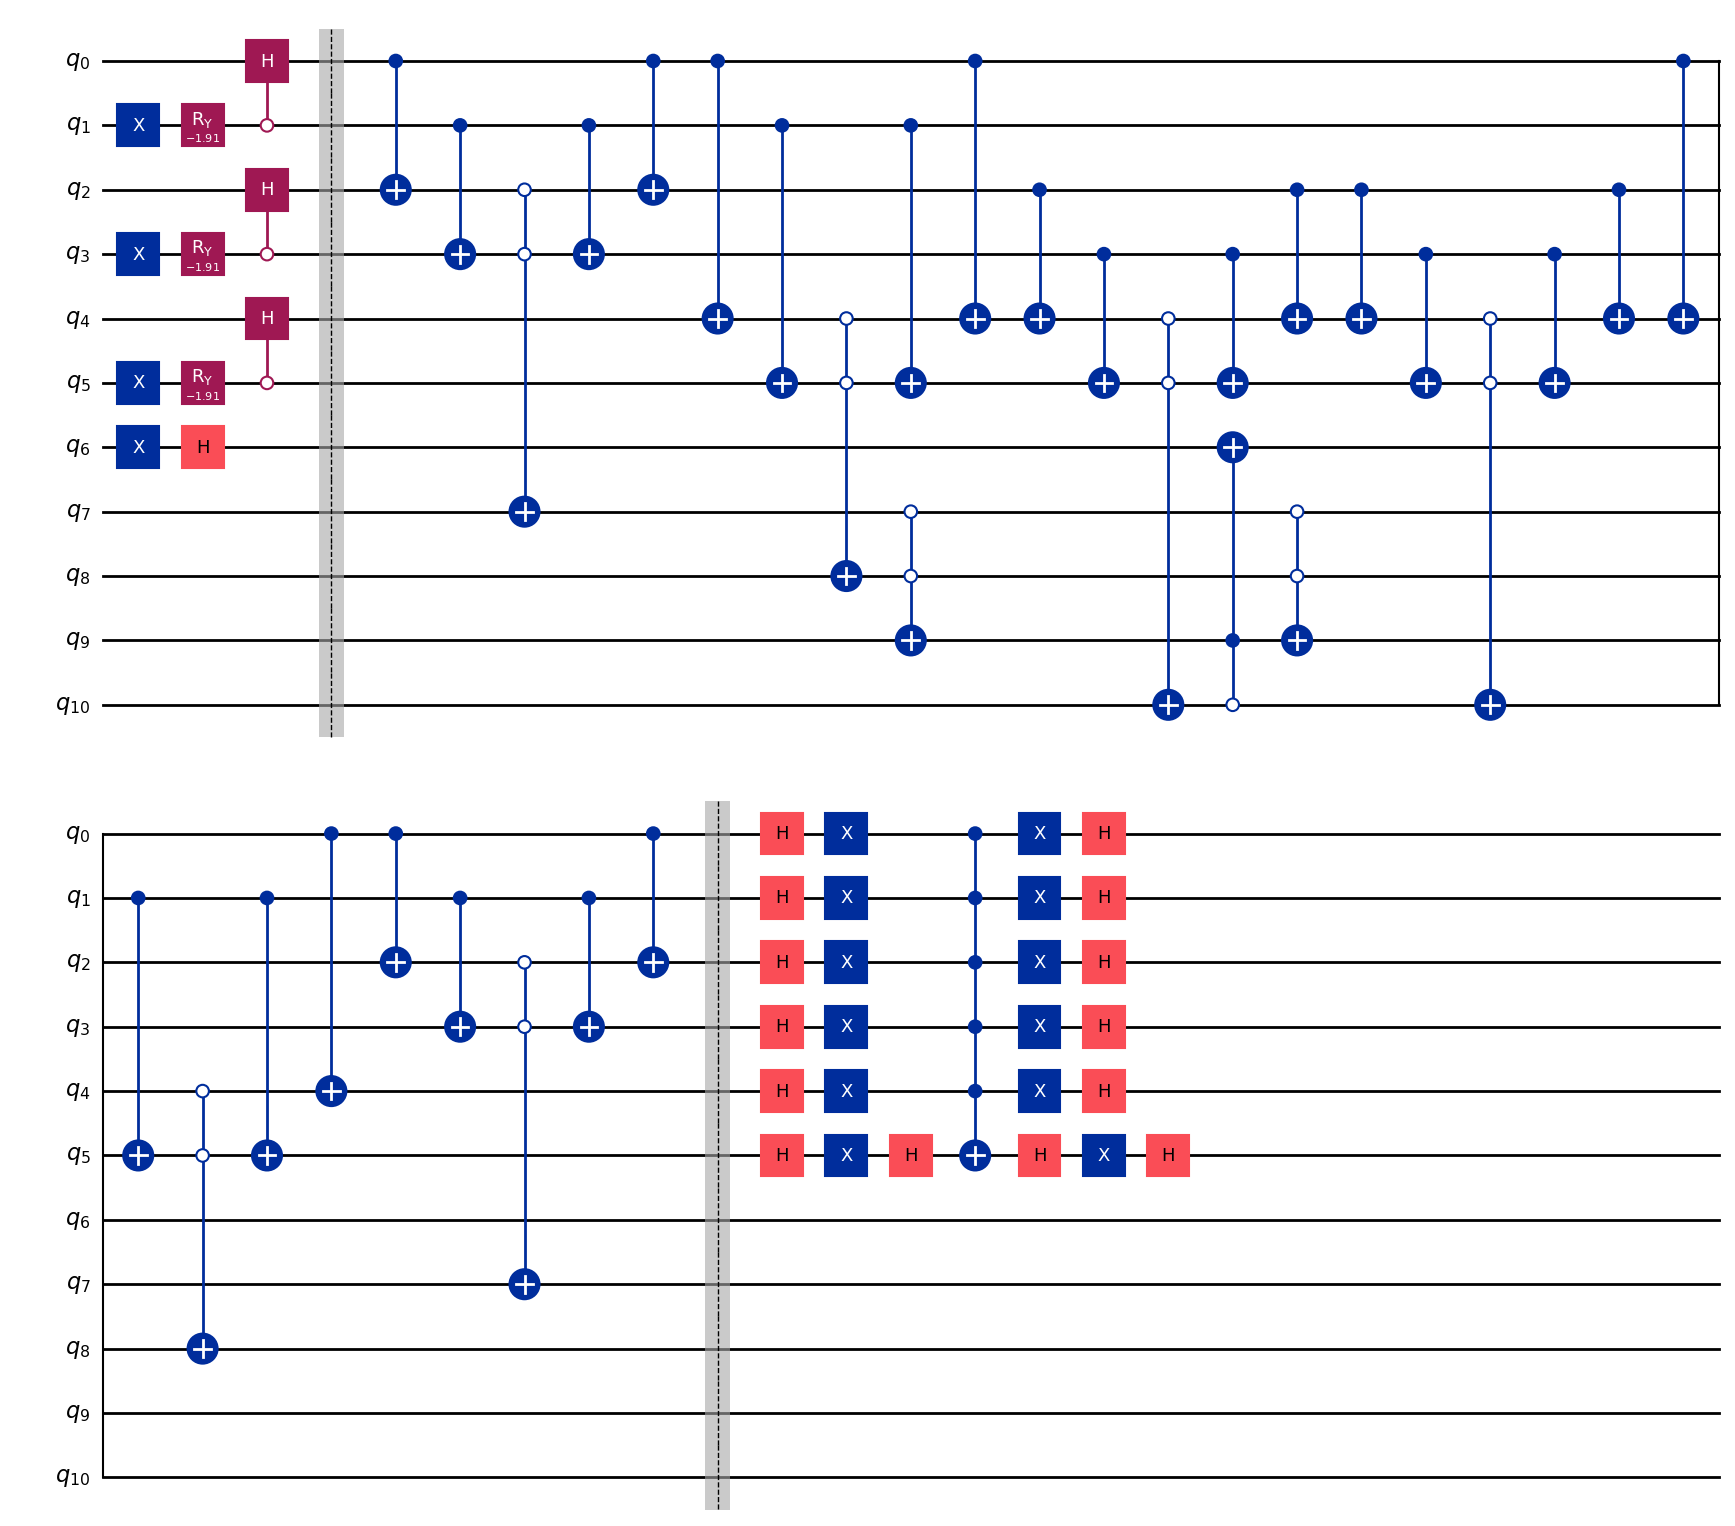

In [10]:
from vcgc.circuit import glue_grover_circuit
# Create the complete Grover circuit
complete_grover_circuit: QuantumCircuit = glue_grover_circuit(
    usp=usp_oracle,
    oracle=oracle_circuit_xag,
    diffusion=diff_oracle,
    num_data_qubits=num_data_qubits,
    num_encode_qubits=num_encode_qubits
)

# Display circuit information
print(f"Complete Grover Circuit:")
print(f"Total qubits: {complete_grover_circuit.num_qubits}")
print(f"Circuit depth: {complete_grover_circuit.depth()}")
print(f"Number of gates: {len(complete_grover_circuit)}")

# Draw the circuit (might be large for complex graphs)
try:
    complete_grover_circuit.draw(output="mpl", fold=20)
except:
    print("Circuit too large to display graphically")
    print(complete_grover_circuit)

complete_grover_circuit.draw(output="mpl")